# Example 4:Portfolio Optimization
Suppose we have a portfolio optimization problem below.
\begin{equation}
    \min_{\omega_1, \cdots, \omega_n}{\sum\limits^n_{i=1}(\rho(\omega_i)+\frac{1}{2}\omega_i^2)}, \qquad \text{s.t.} \ \sum\limits_{i=1}^n \omega_i =1, \ \text{and} \  \sum\limits_{i=1}^n \omega_i r_i \geq \alpha,
\end{equation}

where $n$ is the number of stocks, $\omega_i \in \mathbb{R}$ is the weight of the $i$-th stock with $\omega_i < 0$ meaning shorting the stock and $\omega_i > 0$ longing the stock, $\gamma_i \in \mathbb{R}$ is the expected return of the $i$-th stock, $\alpha \in \mathbb{R}$ is the minimum requirements for the expected return of the portfolio, and $\rho: \mathbb{R} \rightarrow \mathbb{R}^{+} $ is the transaction cost given by a univariate convex PLQ function. The workflow is similar to the previous example except for the input representation of the prototype PLQ function.

In [1]:
import numpy as np
z = np.linspace(-1,1,1000)
interval0 = [1 if (-0.25<=i<=0.25) else 0 for i in z]
interval1 = [1 if (-0.5<=i<-0.25 or 0.25<i<=0.5) else 0 for i in z]
interval2 = [1 if (-0.75<=i<-0.5 or 0.5<i<=0.75) else 0 for i in z]
interval3 = [1 if (i<=-0.75 or i>=0.75) else 0 for i in z]
f = 0.4* (np.abs(z)) * interval0 + (0.8* (np.abs(z)-0.25)+0.1) * interval1 + (1.2* (np.abs(z)-0.5)+0.3) * interval2 + (1.6* (np.abs(z)-0.75)+0.6) * interval3

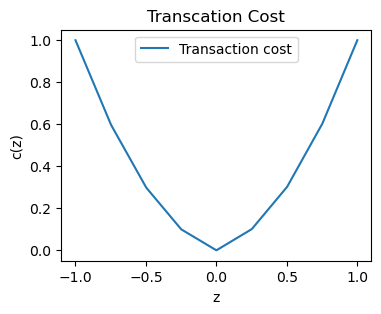

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.plot(z, f, label='Transaction cost')
plt.legend()
plt.xlabel('z')
plt.ylabel('c(z)')
plt.title('Transcation Cost')
plt.show()

# 1.Data Generation

In [3]:
from plqcom import PLQLoss, plq_to_rehloss, affine_transformation
from rehline import ReHLine

In [4]:
# Generate a portfolio dataset
n, C = 10, 0.5
np.random.seed(1024)
X = np.eye(n)
r = -0.5 +np.random.rand(10)

In [5]:
X

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [6]:
r

array([ 0.14769123,  0.49691358,  0.01880326,  0.15811273,  0.09906347,
        0.25306733, -0.36375287, -0.49588288, -0.35049112,  0.198439  ])

# 2. Create and Decompose the PLQ Loss

Create the PLQ Loss object with the points.

In [7]:
# Create a PLQLoss object
plqloss = PLQLoss(points=np.array([[-0.75,0.6],[-0.5,0.3],[-0.25,0.1],[0,0],[0.25,0.1],[0.5,0.3],[0.75,0.6]]),
                  form='points')

Convert the PLQ Loss to ReHLoss by calling its method plq_to_rehloss()

In [8]:
# Decompose the SVM loss into PLQ composite loss
rehloss = plq_to_rehloss(plqloss)

# 3.Broadcast to all samples

For this classication problem,
$L_i(z_i)=L(z)$ hich is a affine transformation of $L(z)$ with $p=1$, $q=0$, $c=0.5$

In [9]:
# Broadcast the PLQ composite loss to all samples
rehloss = affine_transformation(rehloss, n=X.shape[0], c=C, p=1, q=0)

In [10]:
print(rehloss.relu_coef.shape)
print("First ten sample relu coefficients: %s" % rehloss.relu_coef[0][:10])
print("First ten sample relu intercepts: %s" % rehloss.relu_intercept[0][:10])

(6, 10)
First ten sample relu coefficients: [-0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2 -0.2]
First ten sample relu intercepts: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 4. Use ReHLine to solve the problem

In [11]:
A = np.array([r,np.ones(10)])
b = np.array([-0.3,-1])
clf = ReHLine()
clf.U, clf.V, clf.C, clf.A, clf.b = rehloss.relu_coef, rehloss.relu_intercept, C, A, b
clf.fit(X=X)
print('sol privided by rehline: %s' % clf.coef_)

sol privided by rehline: [ 1.34941891e-01  2.54603696e-01  1.69638746e-02  1.44481245e-01
  9.04303147e-02  2.31398247e-01  2.69356477e-18 -5.41557530e-02
 -4.84502846e-19  1.81394027e-01]
